## Notes

This is code revision from https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

Fri, July 1, 2022 | azahrazhr

**CMIIW**

# Autoencoder

torch: This python package provides high-level tensor computation and deep neural networks built on autograd system.

torchvision: This module consists of a wide range of databases, image architectures, and transformations for computer vision

## Step 1: Importing Modules

We will use the torch.optim and the torch.nn module from the torch package and datasets & transforms from torchvision package. In this article, we will be using the popular MNIST dataset comprising grayscale images of handwritten single digits between 0 and 9.

In [ ]:
# pip install torch
# pip install torchvision
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

## Step 2: Loading the Dataset

This snippet loads the MNIST dataset into loader using DataLoader module. The dataset is downloaded and transformed into image tensors. Using the DataLoader module, the tensors are loaded and ready to be used. The dataset is loaded with Shuffling enabled and a batch size of 64.

In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
						train = True,
						download = True,
						transform = tensor_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
									batch_size = 32,
									shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Step 3: Create Autoencoder Class

In this coding snippet, the encoder section reduces the dimensionality of the data sequentially as given by:

    28*28 = 784 ==> 128 ==> 64 ==> 36 ==> 18 ==> 9

Where the number of input nodes is 784 that are coded into 9 nodes in the latent space. Whereas, in the decoder section, the dimensionality of the data is linearly increased to the original input size, in order to reconstruct the input.

    9 ==> 18 ==> 36 ==> 64 ==> 128 ==> 784 ==> 28*28 = 784

Where the input is the 9-node latent space representation and the output is the 28*28 reconstructed input.

The encoder starts with 28*28 nodes in a Linear layer followed by a ReLU layer, and it goes on until the dimensionality is reduced to 9 nodes. The decryptor uses these 9 data representations to bring back the original image by using the inverse of the encoder architecture. The decryptor architecture uses a Sigmoid Layer to range the values between 0 and 1 only.

In [ ]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 9)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(9, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded

## Step 4: Initializing Model

We validate the model using the Mean Squared Error function, and we use an Adam Optimizer with a learning rate of 0.1 and weight decay of 10^{-8}

In [ ]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)

## Step 5: Create Output Generation

The output against each epoch is computed by passing as a parameter into the Model() class and the final tensor is stored in an output list. The image into (-1, 784) and is passed as a parameter to the Autoencoder class, which in turn returns a reconstructed image. The loss function is calculated using MSELoss function and plotted. In the optimizer, the initial gradient values are made to zero using zero_grad(). loss.backward() computes the grad values and stored. Using the step() function, the optimizer is updated.

The original image and the reconstructed image from the outputs list are detached and transformed into a NumPy Array for plotting the images.

Note: This snippet takes 15 to 20 mins to execute, depending on the processor type. Initialize epoch = 1, for quick results. Use a GPU/TPU runtime for faster computations.

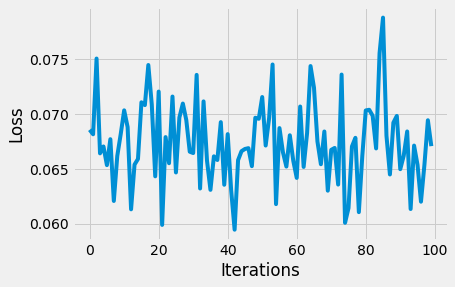

In [ ]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
	for (image, _) in loader:
		
		# Reshaping the image to (-1, 784)
		image = image.reshape(-1, 28*28)
		# Output of Autoencoder
		reconstructed = model(image)
		
		# Calculating the loss function
		loss = loss_function(reconstructed, image)
		
		# The gradients are set to zero,
		# the the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss.detach().numpy())
	outputs.append((epochs, image, reconstructed.detach().numpy()))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])

## Step 6: Input/Reconstructed Input to/from Autoencoder

The first input image array and the first reconstructed input image array have been plotted using plt.imshow().

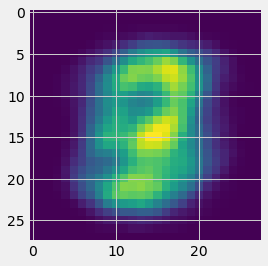

In [ ]:
for i, item in enumerate(image):
	
# Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  plt.imshow(item[0])

for i, item in enumerate(reconstructed.detach().numpy()):
  item = item.reshape(-1, 28, 28)
  plt.imshow(item[0])

Although the rebuilt pictures appear to be adequate, they are extremely grainy. To enhance this outcome, extra layers and/or neurons may be added, or the autoencoder model could be built on convolutions neural network architecture. For dimensionality reduction, autoencoders are quite beneficial. However, it might also be used for data denoising and understanding a dataset’s spread.